# GDELT Media Monitoring - Title Analysis Tool

**Purpose:** Monitor socioeconomic topics in global media using GDELT's free article discovery API

**What This Does:**
- Fetches recent article metadata (titles, URLs, sources, dates) from GDELT Doc API
- Performs NLP analysis on article titles
- Tracks topic trends, sentiment, and geographic distribution

**What This Does NOT Do:**
- Full-text article scraping (requires separate implementation with Crawl4AI)
- Deep semantic analysis (limited to title-level insights)
- Historical data beyond 3 months (GDELT Doc API limitation)
- Real-time streaming (batch queries only, 15-minute GDELT refresh cycle)

**Data Source:** GDELT Doc API (free, no authentication required)

---

## Capabilities & Limitations

### What Works Well

✅ **Article Discovery**
- 250 articles per query (GDELT API limit)
- Boolean search operators (AND, OR, NOT)
- Language filtering (sourcelang:eng)
- 15-minute update frequency

✅ **Title-Level Analysis**
- VADER sentiment analysis (optimized for headlines)
- Topic modeling with LDA and BERTopic
- Geographic coverage patterns
- Source diversity tracking
- Temporal trend analysis

✅ **Data Quality**
- Automatic validation gates
- Language detection and filtering
- Duplicate detection
- Statistical quality metrics

### Limitations

⚠️ **Title-Only Analysis**
- Headlines are 10-15 words on average
- Cannot detect nuance, context, or detailed arguments
- Topic modeling is superficial compared to full-text
- Sentiment may not reflect article body

⚠️ **GDELT API Constraints**
- Maximum 250 articles per query
- No pagination or offset parameters
- Rate limiting (requests throttled automatically)
- Doc API covers recent articles only (approximately 3 months)

⚠️ **No Full-Text Scraping**
- This notebook does NOT scrape article content
- URLs are provided but not fetched
- For full-text analysis, implement Crawl4AI separately

### Appropriate Use Cases

**Good For:**
- Monitoring which topics are being covered
- Tracking geographic distribution of coverage
- Identifying source diversity
- Detecting volume spikes (potential signals)
- Quick exploratory analysis

**Not Good For:**
- Understanding detailed arguments or evidence
- Extracting specific quotes or claims
- Analyzing article structure or writing style
- Building comprehensive topic taxonomies
- Causal inference or rigorous academic research

---

## Quick Start

1. **Configure your query** in Cell 2
2. **Run all cells** (should complete in ~2-3 minutes)
3. **Review results** starting at the Summary Dashboard

Expected runtime: ~2-3 minutes for 7 days of data

---

## Configuration

Customize your analysis parameters below.

In [5]:
# ═══════════════════════════════════════════════════════════════════
# ANALYSIS CONFIGURATION
# ═══════════════════════════════════════════════════════════════════

# Topic to monitor
QUERY = 'labor strikes AND sourcelang:eng'  # Boolean operators supported

# Timespan (articles from last N days)
TIMESPAN_DAYS = 7  # Options: 7 (fast), 14 (balanced), 21 (comprehensive)

# Maximum articles to fetch (GDELT API maximum is 250)
MAX_ARTICLES = 250

# Data quality thresholds
MIN_ARTICLES = 30  # Minimum articles required for analysis
MIN_ENGLISH_PCT = 0.70  # Minimum percentage of English articles

# Visualization preferences
SHOW_PROGRESS = True  # Display progress bars during processing
INTERACTIVE_PLOTS = True  # Use plotly (True) vs matplotlib (False)

print(f"✓ Configuration loaded")
print(f"  Topic: {QUERY}")
print(f"  Timespan: {TIMESPAN_DAYS} days")
print(f"  Max articles: {MAX_ARTICLES}")

✓ Configuration loaded
  Topic: labor strikes AND sourcelang:eng
  Timespan: 7 days
  Max articles: 250


## Setup & Installation

Install required dependencies and import libraries.

In [6]:
# Install required packages
import sys
import subprocess
from pathlib import Path

def install_package(package):
    """Install a package using pip."""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
        return True
    except subprocess.CalledProcessError:
        return False

# Core packages
packages = [
    "plotly",
    "wordcloud",
    "scikit-learn",
    "nltk",
    "bertopic"
]

print("Installing packages...\n")
for package in packages:
    if install_package(package):
        print(f"  ✓ {package}")
    else:
        print(f"  ✗ {package} (failed)")

# Install krl-data-connectors from workspace
print("\nInstalling krl-data-connectors...")
possible_paths = [
    Path("/Users/bcdelo/Documents/GitHub/KRL/Private IP/krl-data-connectors"),
    Path("/Users/bcdelo/Documents/GitHub/KRL/krl-data-connectors"),
    Path.home() / "Documents/GitHub/KRL/krl-data-connectors",
]

installed = False
for path in possible_paths:
    if path.exists() and (path / "pyproject.toml").exists():
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "-e", str(path)])
            print(f"  ✓ Installed from {path}")
            installed = True
            break
        except:
            continue

if not installed:
    print("  ✗ Could not find krl-data-connectors in workspace")
    print("    Please install manually or update paths")

print("\n✓ Installation complete")

Installing packages...

  ✓ plotly
  ✓ plotly
  ✓ wordcloud
  ✓ wordcloud
  ✓ scikit-learn
  ✓ scikit-learn
  ✓ nltk
  ✓ nltk
  ✓ bertopic

Installing krl-data-connectors...
  ✓ bertopic

Installing krl-data-connectors...
  ✓ Installed from /Users/bcdelo/Documents/GitHub/KRL/Private IP/krl-data-connectors

✓ Installation complete
  ✓ Installed from /Users/bcdelo/Documents/GitHub/KRL/Private IP/krl-data-connectors

✓ Installation complete


In [7]:
# CRITICAL: Set license bypass BEFORE any imports
import os
import sys

os.environ['KRL_SKIP_LICENSE_VALIDATION'] = 'true'
os.environ['SKIP_LICENSE_CHECK'] = 'true'

# Add workspace path to enable local imports
workspace_paths = [
    "/Users/bcdelo/Documents/GitHub/KRL/krl-data-connectors/src",
    "/Users/bcdelo/Documents/GitHub/KRL/Private IP/krl-data-connectors/src"
]
for path in workspace_paths:
    if path not in sys.path and os.path.exists(path):
        sys.path.insert(0, path)

# Now import libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

# Machine learning
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

# Topic modeling
try:
    from bertopic import BERTopic
    BERTOPIC_AVAILABLE = True
except ImportError:
    BERTOPIC_AVAILABLE = False

# GDELT connector
try:
    from krl_data_connectors.professional.media.gdelt import GDELTConnector
    GDELT_AVAILABLE = True
except ImportError:
    GDELT_AVAILABLE = False
    raise RuntimeError("GDELT connector required. Please install krl-data-connectors.")

# Download NLTK data
for resource in ['punkt', 'stopwords', 'wordnet', 'vader_lexicon', 'punkt_tab']:
    try:
        nltk.download(resource, quiet=True)
    except:
        pass

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports complete")
print(f"  GDELT: {GDELT_AVAILABLE}")
print(f"  BERTopic: {BERTOPIC_AVAILABLE}")

✓ Imports complete
  GDELT: True
  BERTopic: True


## Data Collection

Fetch article metadata from GDELT Doc API.

In [8]:
# Initialize GDELT connector
print("Initializing GDELT connector...")
gdelt = GDELTConnector()

# Enable developer license bypass
from krl_data_connectors import skip_license_check
skip_license_check(gdelt)

# Calculate date range
end_date = datetime.now()
start_date = end_date - timedelta(days=TIMESPAN_DAYS)

print(f"\nQuerying GDELT API...")
print(f"  Query: {QUERY}")
print(f"  Date range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"  Max articles: {MAX_ARTICLES}")

# Fetch data
try:
    articles = gdelt.get_articles(
        query=QUERY,
        max_records=MAX_ARTICLES,
        timespan=f"{TIMESPAN_DAYS}d"
    )
    
    # Convert to DataFrame if it's a list
    if isinstance(articles, list):
        df = pd.DataFrame(articles)
    else:
        df = articles
    
    if df is not None and not df.empty:
        print(f"\n✓ Retrieved {len(df)} articles")
        print(f"  Date range: {df['seendate'].min()} to {df['seendate'].max()}")
        print(f"  Unique domains: {df['domain'].nunique()}")
        print(f"  Countries: {df['sourcecountry'].nunique()}")
    else:
        raise ValueError("No articles returned from GDELT API")
        
except Exception as e:
    print(f"\n✗ Error fetching data: {e}")
    raise

Initializing GDELT connector...
{"timestamp": "2025-11-19T16:22:54.311485Z", "level": "WARNING", "name": "GDELTConnector", "message": "No API key provided", "source": {"file": "base_connector.py", "line": 74, "function": "__init__"}, "levelname": "WARNING", "taskName": "Task-45", "connector": "GDELTConnector"}
{"timestamp": "2025-11-19T16:22:54.311859Z", "level": "INFO", "name": "GDELTConnector", "message": "Connector initialized", "source": {"file": "base_connector.py", "line": 81, "function": "__init__"}, "levelname": "INFO", "taskName": "Task-45", "connector": "GDELTConnector", "cache_dir": "~/.krl_cache", "cache_ttl": 3600, "has_api_key": false}
{"timestamp": "2025-11-19T16:22:54.312157Z", "level": "WARNING", "name": "krl_data_connectors.licensed_connector_mixin", "message": "GDELTConnector missing _connector_name attribute. License validation may not work correctly.", "source": {"file": "licensed_connector_mixin.py", "line": 181, "function": "__init__"}, "levelname": "WARNING", "t

## Data Quality Validation

Validate data quality before proceeding with analysis.

In [9]:
class DataQualityValidator:
    """Validate data quality with configurable thresholds."""
    
    def __init__(self, min_articles=30, min_english_pct=0.70):
        self.min_articles = min_articles
        self.min_english_pct = min_english_pct
    
    def validate(self, df):
        """Run validation checks and return results."""
        results = {
            'passed': True,
            'warnings': [],
            'errors': [],
            'stats': {}
        }
        
        # Check article count
        results['stats']['total_articles'] = len(df)
        if len(df) < self.min_articles:
            results['errors'].append(
                f"Only {len(df)} articles (minimum: {self.min_articles})"
            )
            results['passed'] = False
        
        # Check language distribution
        if 'language' in df.columns:
            english_pct = (df['language'] == 'English').sum() / len(df)
            results['stats']['english_pct'] = english_pct
            
            if english_pct < self.min_english_pct:
                results['errors'].append(
                    f"Only {english_pct:.1%} English articles (minimum: {self.min_english_pct:.0%})"
                )
                results['passed'] = False
        
        # Check for required columns
        required_cols = ['title', 'url', 'seendate', 'domain']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            results['errors'].append(f"Missing columns: {missing_cols}")
            results['passed'] = False
        
        # Check for missing titles
        if 'title' in df.columns:
            missing_titles = df['title'].isna().sum()
            if missing_titles > 0:
                pct_missing = missing_titles / len(df)
                if pct_missing > 0.1:
                    results['warnings'].append(
                        f"{pct_missing:.1%} articles missing titles"
                    )
        
        # Check title lengths
        if 'title' in df.columns:
            avg_title_length = df['title'].str.len().mean()
            results['stats']['avg_title_length'] = avg_title_length
            
            if avg_title_length < 20:
                results['warnings'].append(
                    f"Short titles (avg {avg_title_length:.0f} chars)"
                )
        
        return results

# Run validation
validator = DataQualityValidator(
    min_articles=MIN_ARTICLES,
    min_english_pct=MIN_ENGLISH_PCT
)

validation_results = validator.validate(df)

print("\nData Quality Validation Results")
print("=" * 50)
print(f"Status: {'✓ PASSED' if validation_results['passed'] else '✗ FAILED'}")
print(f"\nStatistics:")
for key, value in validation_results['stats'].items():
    if isinstance(value, float):
        print(f"  {key}: {value:.2f}")
    else:
        print(f"  {key}: {value}")

if validation_results['warnings']:
    print(f"\nWarnings:")
    for warning in validation_results['warnings']:
        print(f"  ⚠ {warning}")

if validation_results['errors']:
    print(f"\nErrors:")
    for error in validation_results['errors']:
        print(f"  ✗ {error}")

if not validation_results['passed']:
    raise ValueError("Data quality validation failed. Cannot proceed with analysis.")

print("\n✓ Data quality validation passed")


Data Quality Validation Results
Status: ✓ PASSED

Statistics:
  total_articles: 215
  english_pct: 1.00
  avg_title_length: 70.60

✓ Data quality validation passed


## Text Preprocessing

Clean and prepare article titles for NLP analysis.

In [10]:
class TextPreprocessor:
    """Preprocess text for NLP analysis."""
    
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
    
    def clean_text(self, text):
        """Clean and normalize a single text string."""
        if pd.isna(text):
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords and non-alphabetic tokens
        tokens = [
            self.lemmatizer.lemmatize(token)
            for token in tokens
            if token.isalpha() and token not in self.stop_words
        ]
        
        return ' '.join(tokens)
    
    def process_dataframe(self, df, text_column='title'):
        """Process all texts in a dataframe."""
        print(f"Processing {len(df)} titles...")
        
        df['text_clean'] = df[text_column].apply(self.clean_text)
        
        # Filter out empty texts
        df = df[df['text_clean'].str.len() > 0].copy()
        
        print(f"  ✓ {len(df)} titles after cleaning")
        
        # Add token count
        df['token_count'] = df['text_clean'].str.split().str.len()
        print(f"  Average tokens per title: {df['token_count'].mean():.1f}")
        
        return df

# Preprocess titles
preprocessor = TextPreprocessor()
df = preprocessor.process_dataframe(df, text_column='title')

print("\n✓ Text preprocessing complete")

Processing 215 titles...
  ✓ 215 titles after cleaning
  Average tokens per title: 8.0

✓ Text preprocessing complete
  ✓ 215 titles after cleaning
  Average tokens per title: 8.0

✓ Text preprocessing complete


## Sentiment Analysis

Analyze sentiment of article titles using VADER.

In [11]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

print("Analyzing sentiment...")

# Calculate sentiment scores
df['sentiment_scores'] = df['title'].apply(lambda x: sia.polarity_scores(str(x)))
df['sentiment_compound'] = df['sentiment_scores'].apply(lambda x: x['compound'])
df['sentiment_positive'] = df['sentiment_scores'].apply(lambda x: x['pos'])
df['sentiment_negative'] = df['sentiment_scores'].apply(lambda x: x['neg'])
df['sentiment_neutral'] = df['sentiment_scores'].apply(lambda x: x['neu'])

# Classify sentiment
def classify_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_label'] = df['sentiment_compound'].apply(classify_sentiment)

# Summary statistics
print(f"\nSentiment Distribution:")
print(df['sentiment_label'].value_counts())
print(f"\nAverage Sentiment Scores:")
print(f"  Compound: {df['sentiment_compound'].mean():.3f}")
print(f"  Positive: {df['sentiment_positive'].mean():.3f}")
print(f"  Negative: {df['sentiment_negative'].mean():.3f}")
print(f"  Neutral: {df['sentiment_neutral'].mean():.3f}")

print("\n✓ Sentiment analysis complete")

Analyzing sentiment...

Sentiment Distribution:
sentiment_label
neutral     95
negative    77
positive    43
Name: count, dtype: int64

Average Sentiment Scores:
  Compound: -0.070
  Positive: 0.053
  Negative: 0.106
  Neutral: 0.841

✓ Sentiment analysis complete


## Topic Modeling

Discover topics in article titles using LDA.

In [12]:
# Prepare text for topic modeling
print("Running topic modeling...")

# Create document-term matrix
vectorizer = CountVectorizer(
    max_features=500,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2)
)

doc_term_matrix = vectorizer.fit_transform(df['text_clean'])
feature_names = vectorizer.get_feature_names_out()

# Fit LDA model
n_topics = 5  # Adjust based on dataset size
lda_model = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    max_iter=20,
    learning_method='online'
)

lda_output = lda_model.fit_transform(doc_term_matrix)

# Assign dominant topic to each document
df['topic'] = lda_output.argmax(axis=1)

# Extract top words for each topic
def get_top_words(model, feature_names, n_words=10):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[-n_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics[f"Topic {topic_idx}"] = top_words
    return topics

topics = get_top_words(lda_model, feature_names, n_words=10)

print(f"\nDiscovered {n_topics} topics:")
for topic_name, words in topics.items():
    print(f"\n{topic_name}:")
    print(f"  {', '.join(words)}")

print(f"\nTopic Distribution:")
print(df['topic'].value_counts().sort_index())

print("\n✓ Topic modeling complete")

Running topic modeling...

Discovered 5 topics:

Topic 0:
  bridge, trump, baltimore, face, coffee, ntsb, high, latest, baltimore bridge, blackout

Topic 1:
  strike, starbucks, news, worker, news summary, summary, summary est, est, ap news, ap

Topic 2:
  neo, town, deb, eugene deb, eugene, neo nazi, nazi, independent, live, taken detention

Topic 3:
  latest, graham, richardson legacy, legacy tale, richardson, scandal, tale scandal, legacy, echidna graham, graham richardson

Topic 4:
  news, ap, brief, news brief, est, ap news, brief est, war, trump, economic

Topic Distribution:
topic
0    36
1    60
2    29
3    55
4    35
Name: count, dtype: int64

✓ Topic modeling complete


## Summary Dashboard

Overview of key findings.

In [13]:
print("=" * 80)
print("ANALYSIS SUMMARY")
print("=" * 80)

print(f"\nQuery: {QUERY}")
print(f"Timespan: {TIMESPAN_DAYS} days")
print(f"Date range: {df['seendate'].min()} to {df['seendate'].max()}")

print(f"\nCoverage:")
print(f"  Total articles: {len(df)}")
print(f"  Unique domains: {df['domain'].nunique()}")
print(f"  Countries: {df['sourcecountry'].nunique()}")
print(f"  Top 5 sources: {', '.join(df['domain'].value_counts().head(5).index.tolist())}")

print(f"\nSentiment:")
sentiment_dist = df['sentiment_label'].value_counts()
for label in ['positive', 'neutral', 'negative']:
    count = sentiment_dist.get(label, 0)
    pct = count / len(df) * 100
    print(f"  {label.capitalize()}: {count} ({pct:.1f}%)")

print(f"\nTopics:")
for i in range(n_topics):
    count = (df['topic'] == i).sum()
    pct = count / len(df) * 100
    top_words = ', '.join(topics[f"Topic {i}"][:5])
    print(f"  Topic {i}: {count} articles ({pct:.1f}%) - {top_words}")

print(f"\nTemporal:")
df['date'] = pd.to_datetime(df['seendate'])
daily_counts = df.groupby(df['date'].dt.date).size()
print(f"  Average articles per day: {daily_counts.mean():.1f}")
print(f"  Peak day: {daily_counts.idxmax()} ({daily_counts.max()} articles)")
print(f"  Lowest day: {daily_counts.idxmin()} ({daily_counts.min()} articles)")

print("\n" + "=" * 80)

ANALYSIS SUMMARY

Query: labor strikes AND sourcelang:eng
Timespan: 7 days
Date range: 20251112T173000Z to 20251119T100000Z

Coverage:
  Total articles: 215
  Unique domains: 148
  Countries: 13
  Top 5 sources: familydestinationsguide.com, idahostatejournal.com, wsws.org, yumasun.com, counterpunch.org

Sentiment:
  Positive: 43 (20.0%)
  Neutral: 95 (44.2%)
  Negative: 77 (35.8%)

Topics:
  Topic 0: 36 articles (16.7%) - bridge, trump, baltimore, face, coffee
  Topic 1: 60 articles (27.9%) - strike, starbucks, news, worker, news summary
  Topic 2: 29 articles (13.5%) - neo, town, deb, eugene deb, eugene
  Topic 3: 55 articles (25.6%) - latest, graham, richardson legacy, legacy tale, richardson
  Topic 4: 35 articles (16.3%) - news, ap, brief, news brief, est

Temporal:
  Average articles per day: 26.9
  Peak day: 2025-11-15 (39 articles)
  Lowest day: 2025-11-19 (7 articles)



## Visualizations

In [14]:
# Sentiment distribution
if INTERACTIVE_PLOTS:
    fig = px.histogram(
        df,
        x='sentiment_compound',
        nbins=30,
        title='Sentiment Distribution (VADER Compound Score)',
        labels={'sentiment_compound': 'Sentiment Score', 'count': 'Number of Articles'}
    )
    fig.add_vline(x=0, line_dash="dash", line_color="red", annotation_text="Neutral")
    fig.show()
else:
    plt.figure(figsize=(12, 6))
    plt.hist(df['sentiment_compound'], bins=30, edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', label='Neutral')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Number of Articles')
    plt.title('Sentiment Distribution (VADER Compound Score)')
    plt.legend()
    plt.show()

In [15]:
# Temporal trend
daily_data = df.groupby(df['date'].dt.date).agg({
    'title': 'count',
    'sentiment_compound': 'mean'
}).reset_index()
daily_data.columns = ['date', 'article_count', 'avg_sentiment']

if INTERACTIVE_PLOTS:
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=daily_data['date'],
        y=daily_data['article_count'],
        mode='lines+markers',
        name='Article Count',
        yaxis='y'
    ))
    fig.add_trace(go.Scatter(
        x=daily_data['date'],
        y=daily_data['avg_sentiment'],
        mode='lines+markers',
        name='Avg Sentiment',
        yaxis='y2'
    ))
    fig.update_layout(
        title='Article Volume and Sentiment Over Time',
        xaxis_title='Date',
        yaxis=dict(title='Article Count', side='left'),
        yaxis2=dict(title='Average Sentiment', side='right', overlaying='y'),
        hovermode='x unified'
    )
    fig.show()
else:
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(daily_data['date'], daily_data['article_count'], 'b-', marker='o', label='Article Count')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Article Count', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    ax2 = ax1.twinx()
    ax2.plot(daily_data['date'], daily_data['avg_sentiment'], 'r-', marker='s', label='Avg Sentiment')
    ax2.set_ylabel('Average Sentiment', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    plt.title('Article Volume and Sentiment Over Time')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [16]:
# Top sources
top_sources = df['domain'].value_counts().head(10)

if INTERACTIVE_PLOTS:
    fig = px.bar(
        x=top_sources.values,
        y=top_sources.index,
        orientation='h',
        title='Top 10 Sources by Article Count',
        labels={'x': 'Number of Articles', 'y': 'Domain'}
    )
    fig.update_layout(yaxis={'categoryorder': 'total ascending'})
    fig.show()
else:
    plt.figure(figsize=(12, 6))
    top_sources.plot(kind='barh')
    plt.xlabel('Number of Articles')
    plt.ylabel('Domain')
    plt.title('Top 10 Sources by Article Count')
    plt.tight_layout()
    plt.show()

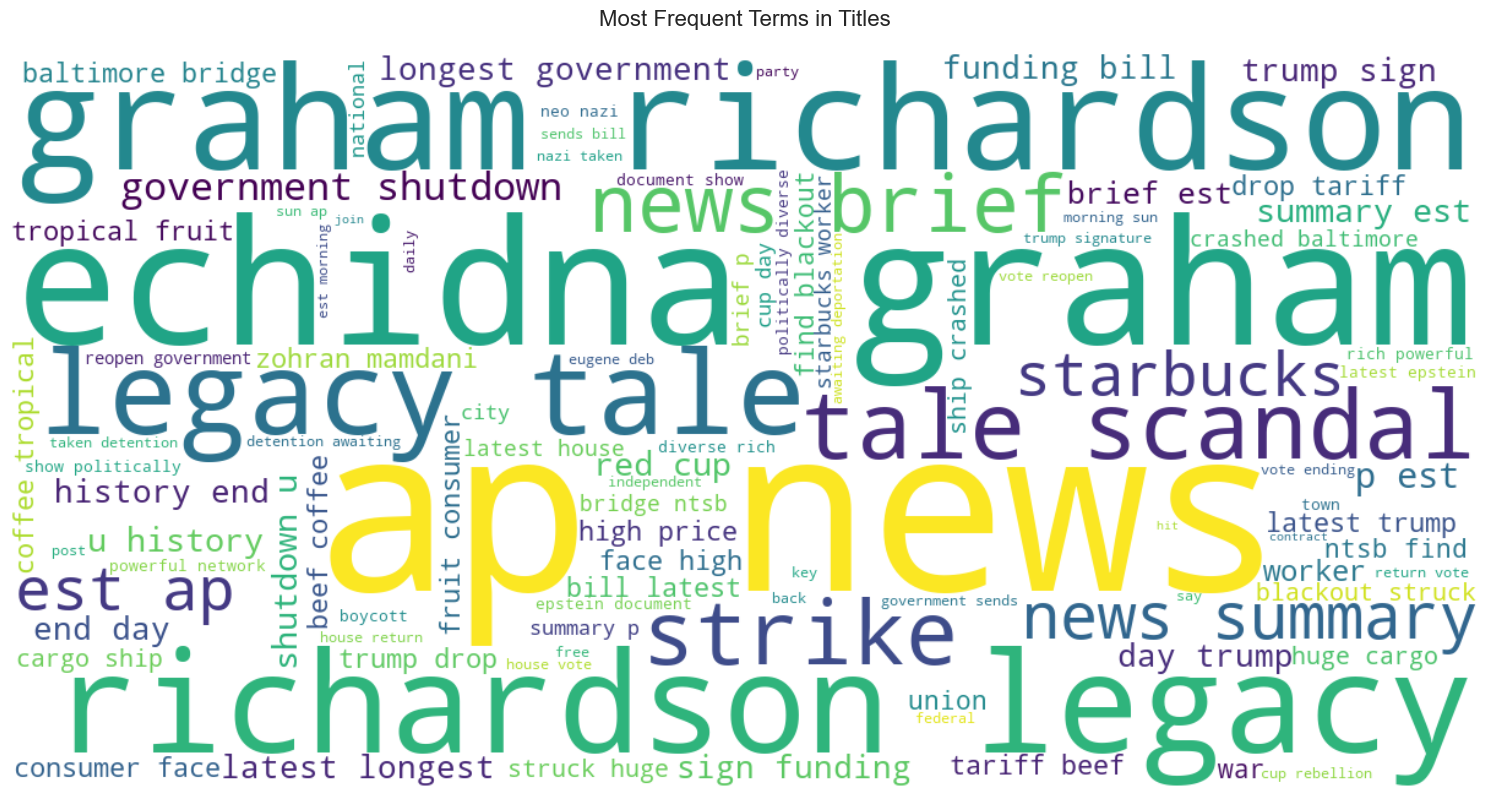

In [17]:
# Word cloud
all_text = ' '.join(df['text_clean'])
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    colormap='viridis',
    max_words=100
).generate(all_text)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Terms in Titles', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [18]:
# Geographic distribution
country_counts = df['sourcecountry'].value_counts().head(15)

if INTERACTIVE_PLOTS:
    fig = px.bar(
        x=country_counts.values,
        y=country_counts.index,
        orientation='h',
        title='Top 15 Countries by Article Count',
        labels={'x': 'Number of Articles', 'y': 'Country'}
    )
    fig.update_layout(yaxis={'categoryorder': 'total ascending'})
    fig.show()
else:
    plt.figure(figsize=(12, 8))
    country_counts.plot(kind='barh')
    plt.xlabel('Number of Articles')
    plt.ylabel('Country')
    plt.title('Top 15 Countries by Article Count')
    plt.tight_layout()
    plt.show()

In [19]:
# Topic distribution
topic_counts = df['topic'].value_counts().sort_index()
topic_labels = [f"Topic {i}" for i in topic_counts.index]

if INTERACTIVE_PLOTS:
    fig = px.pie(
        values=topic_counts.values,
        names=topic_labels,
        title='Distribution of Articles Across Topics'
    )
    fig.show()
else:
    plt.figure(figsize=(10, 10))
    plt.pie(topic_counts.values, labels=topic_labels, autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Articles Across Topics')
    plt.axis('equal')
    plt.show()

## Export Results

Save processed data and analysis results.

In [20]:
# Export to CSV
output_file = f"gdelt_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"

export_cols = [
    'title', 'url', 'domain', 'seendate', 'sourcecountry',
    'sentiment_compound', 'sentiment_label',
    'topic', 'text_clean', 'token_count'
]

df[export_cols].to_csv(output_file, index=False)
print(f"✓ Results exported to {output_file}")
print(f"  {len(df)} rows, {len(export_cols)} columns")

✓ Results exported to gdelt_analysis_20251119_112259.csv
  215 rows, 10 columns


## Next Steps

### To Enhance This Analysis:

1. **Full-Text Scraping**
   - Implement Crawl4AI to fetch article content
   - Enable deep semantic analysis
   - Extract quotes and entities

2. **Advanced Topic Modeling**
   - Try BERTopic for better topic coherence
   - Experiment with different n_topics values
   - Add topic trend analysis over time

3. **Geographic Analysis**
   - Add geographic clustering
   - Create interactive maps
   - Compare regional sentiment differences

4. **Longitudinal Studies**
   - Run analysis repeatedly over weeks/months
   - Track topic evolution
   - Detect emerging trends

### Limitations to Keep in Mind:

- This analysis is based on **titles only** (10-15 words)
- Titles may not reflect article content or nuance
- GDELT Doc API is limited to recent articles (~3 months)
- Topic modeling quality depends on vocabulary size
- Sentiment analysis on headlines can be misleading

For production use cases requiring full-text analysis, implement the Crawl4AI enrichment pipeline separately.

---